# 07-3 신경망 모델 훈련
##### 인공 신경망 모델을 훈련하는 모범 사례와 팔요한 도구들을 살펴보겠습니다. 텐서플로와 케라스 API에 익숙해지자

- 이전까지 인공 신경망에 대해 배우고 텐서플로 케라스 API를 사용해 직접 개발 실습함
- 사이킷런에서 제공하는 머신러닝 알고리즘들은 좋은 성능을 내기 위해 매개변수를 조정하고 훈련하는 과정을 반복함
- 알고리즘 모델의 구조가 어느 정도 고정되어 있음
- 딥러닝은 모델 구조를 직접 만들 수 있음
  - 층을 추가하고 층에 있는 뉴런 개수와 활성화 함수를 결정하는 일
  - 프로그래머에게는 텐서플로, 케라스 딥러닝 라이브러리가 친숙할 수 있음
  - 딥러닝 분야는 연구자와 프로그래머가 더 밀접하게 일하게 됨
- 케라스 API를 사용해 모델을 훈련하는데 필요한 도구를 알아보고 필요한 중요 개념과 모범 사례를 살펴보자

### 손실 곡선
- history 지표는 훈련 과정에서 히스토리 값이 저장되어 있음
- `<keras.src.callbacks.History at 0x1402030d0>`


In [39]:
# 위의 값을 사용하면 그래프를 그릴 수 있음 
# 훈련셋, 데이터셋을 나누어보자

from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

- 모델 만들기
- 이번에는 함수를 정의하여 모델을 만듦

In [40]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

- if 구문으로 model_fn() 함수에 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가
- a_layer 매개변수로 층을 추가하지 않고 단순하게 model_fn() 함수 호출
- 여기서는 a_layer로 층을 추가하지 않고 단순하게 함수만 호출하여 확인

In [12]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 이전 절과 동일하게 모델 훈련함
- fit() 메서드 결과를 history 변수에 담아 확인

In [13]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

- `verbose` 매개변수 : 출력 조절
  - 0 : 훈련 과정 출력하지 않음
  - 1 : 기본값, 에포크마다 진행 막대, 손실 등의 지표 출력
  - 2 : 진행 막대 빼고 출력
- history 객체는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어있음

In [14]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


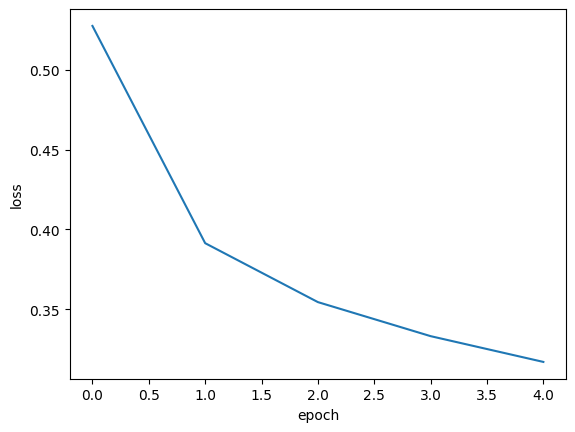

In [15]:
# 맷플롯립으로 그래프를 그려보자
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

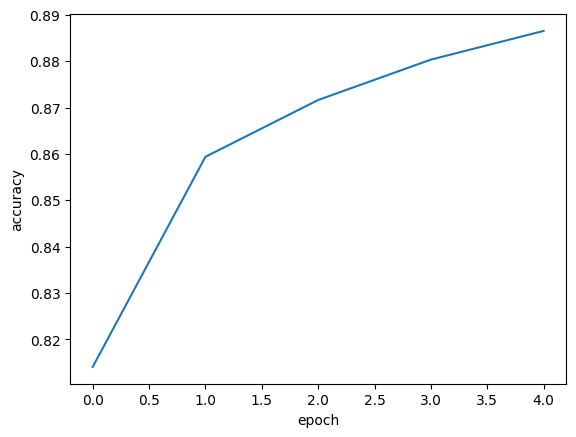

In [16]:
# 정확도 출력
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

- 에포크마다 손실이 감소하고 정확도가 향상하는 것을 확인할 수 있음
- 에포크를 늘려서 손실을 확인해보자

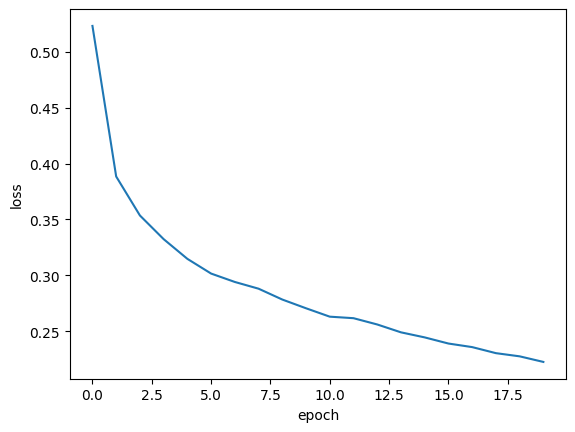

In [17]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 검증 손실
- 앞서 확률적 경사 하강법 사용시 과대/과소적합과 에포크 사이의 관계를 알아보았음
- 에포크에 따른 과대/과소적합을 파악하려면 훈련 세트의 점수, 검증 세트에 대한 점수도 필요
- 4장에서는 정확도를 사용하여 과대/과소적합을 설명
- 이번에는 손실을 사용하여 과대/과소적합을 확인
- 아래와 같은 그래프가 그려질 것으로 예상

![검증손실](./images/dnn-398-1.jpg)

- 손실을 사용하는 것과 정확도를 사용하는 것의 차이점
  - 인공 신경망 모델이 최적화하는 대상은 정확도가 아닌 손실 함수임
  - 손실 감소에 비례하여 정확도가 높아지지 않는 경우도 있음
  - 모델이 잘 훈련되었는지 판단하려면 정확도보다는 손실 함수의 값을 확인하는 것이 더 좋음
- 에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit() 메서드에 검증 데이터를 전달할 수 있음
- validation_data 매배견수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달

In [24]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [25]:
# 반환된 딕셔너리에 어떤 값이 들어있는지 확인
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


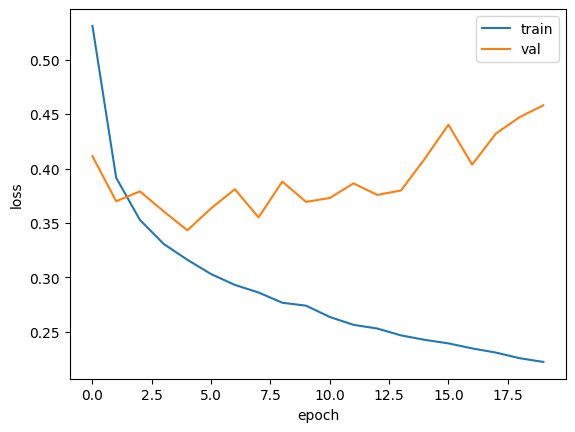

In [26]:
# 과대적합, 과소적합 확인을 위해 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 검증 손실이 감소하다가 5번째 에포크 만에 다시 상승
- 훈련 손실은 꾸준히 감소 -> 에포크가 많아질수록 과대적합 모델이 만들어짐
- 검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐 아니라 검증 세트에 대한 정확도도 증가할 것
- 기본 RMSprop 옵티마이저는 많은 문제에서 잘 동작함
- Adam 옵티마이저를 적용해보자
- 다음장에서 과대적합을 막기 위해 신경망에 특화된 규제 방법을 다음 섹션에서 확인해볼 것

In [27]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

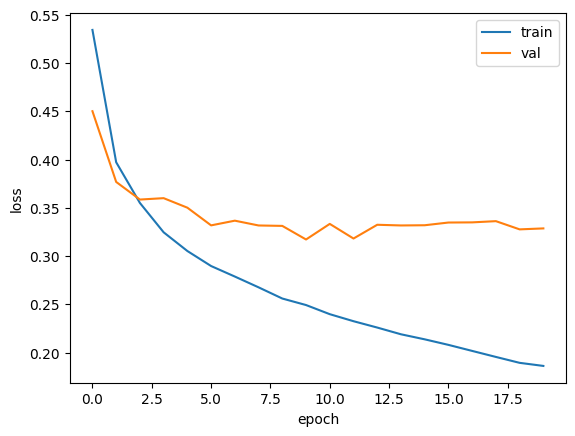

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 과대적합이 훨씬 줄었음
- 검증 손실 그래프에 여전히 요동이 남았지만 10번째 에포크까지 전반적으로 감소 추세
- Adam 옵티마이저가 이 데이터셋에 더 잘 맞는다는 것
- 더 나은 손실 곡선을 찾기 위해 학습률을 조정해서 시도 가능 
- 이제 신경망에서 사용하는 대표적인 규제 방법을 알아보자

### 드롭아웃
- 제프리 힌턴이 소개
- 아래 그림 처럼 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(뉴런의 출력을 0으로 만들어서) 과대적합을 막음
![드롭아웃](./images/dnn-401-1.jpg)
- 어떤 샘플을 처리할 때 두 번째 뉴런이 드롭아웃되어 h<sub>2</sub> 출력이 없음
- 다른 샘플을 처리할 때는 h<sub>1</sub> 출력이 없음
- 뉴런은 랜덤하게 드롭아웃고 드롭할 뉴런의 개수를 정하는 것이 또 다른 하이퍼파라미터임
- 또 다른 해석은 드롭아웃이 적용된 2개의 신경망이 마치 앙상블 하는 것처럼 여겨질 수 있음
- 케라스 레이어에 패키지 아래 Dropout 클래스로 제공

In [29]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 은닉층이 추가된 드롭아웃 층(Dropout)은 훈련되는 모델 파라미터가 없음
- 입출력 크기가 같음 -> 일부 뉴런 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않음
- 평가나 예측에서는 드롭아웃이 적용되지 않아야 함 -> 케라스가 자동으로 해줌

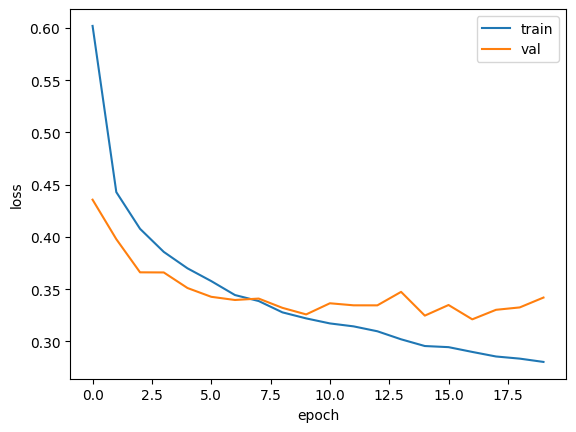

In [31]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 과적합이 줄어든 것을 확인! -> 열 번째 에포크 정도에서 검증 손실 감소가 멈추고 유지되고 있음
- 해당 모델은 과대적합 되지 않은 모델을 얻기 위해 에포크 횟수를 10으로 조정해야 할 것

### 모델 저장과 복원
- 에포크 10으로 다시 모델 훈련
- 배포를 위해 모델을 저장해야 함

In [33]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

- 케라스 모델은 훈련된 모델 파라미터를 저장하는 `save_weights()` 메서드를 제공
- 메서드는 텐서플로 체크포인트 포멧으로 저장하지만 확장자가 `.h5`일 경우 HDF5 포멧으로 저장

In [34]:
model.save_weights('model-weights.h5')

- 모델 구조와 모델 파라미터를 함께 저장하는 `save()` 메서드 제공
- 기본적으로 SavedModel 포멧으로 저장하지만 책에서는 HDF5 포멧으로 저장

In [35]:
model.save('model-whole.h5')

/Users/jeremyshin/.pyenv/versions/3.11.3/envs/hongong/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# 파일 확인
!ls -al *.h5

-rw-r--r--  1 jeremyshin  staff  333320 12 27 17:20 model-weights.h5
-rw-r--r--  1 jeremyshin  staff  981176 12 27 17:21 model-whole.h5


- 두 가지 경우를 확인
1. 훈련을 하지 않은 새로운 모델을 만들고 model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용
2. model-whole.h5 파일에서 새로운 모델을 만들어 바로 사용

- 첫 번째 경우부터 확인

In [37]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

- 훈련하지 않은 새 모델을 만들고 이전에 저장했던 모델 파라미터 적용 (load_weights())
  - 참고 : load_weights() 메서드 사용하려면 save_weights() 메서드로 저장했던 모델과 정확히 같은 구조를 가져야 함
- 모델 검증 정확도 확인
  - 케라스에서 predict() 메서드는 샘플마다 10개의 클래스에 대한 확률을 반환
- 패션 MNIST 데이터셋에서 덜어낸 검증 세트의 샘플 개수는 12,000개 -> predict() 메서드는 (12000, 10) 크기의 배열 반환
- 10개 확률 중 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도 계산
  - 모델 파라미터를 읽은 후 evaluate() 메서드를 사용하여 정확도를 출력할 수도 있음
  - evaluate() 메서드는 손실 계산을 위해 compile() 메서드를 실행해야하므로 책에서는 새로운 데이터에 대한 정확도만 계산하는 상황이라고 가정

In [42]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 0s 896us/step
0.8810833333333333


- 넘파이 argmax() 함수는 배열에서 가장 큰 값의 인덱스를 반환
  - argmax() 함수의 axis=-1은 배열의 마지막 차원을 따라 최댓값을 고름
  - 검증 세트는 2차원이기 때문에 마지막 차원은 1
    - axis=1 열을 따라 각 행의 최댓값 인덱스 선택
    - axis=0 행을 따라 각 열의 최댓값 인덱스 선택
- argmax()로 고른 인덱스(val_lables)와 타깃(val_target)을 비교
  - 두 배열에서 각 위치의 값이 같으면 1이되고 다르면 0이됨 -> 이를 평균하면 정확도

- 두 번쨰 경우 확인
- 모델 전체를 파일에서 읽은 후 검증 세트의 정확도 출력

In [43]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 0s 1ms/step - loss: 0.3311 - accuracy: 0.8811


[0.3311130106449127, 0.8810833096504211]

- 같은 모델을 불러와 동일한 결과를 얻을 수 있었음
- 참고 : load_model() 함수는 모델 파라미터뿐만 아니라 모델 구조와 옵티마이저 상태까지 보두 복원하기 때문에 evaluate() 메서드 사용 가능
- 위의 과정에서 20번의 에포크 동안 모델을 훈련하고 검증 점수가 상승하는 지점을 확인 후 10번의 에포크만큼 다시 훈련
- 모델을 두 번씩 훈련하지 않고 한 번에 끝낼 수 있는 콜백을 사용

### 콜백
- 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체 keras.callbacks 패키지 아래 있는 클래스들
- fit() 메서드에 callbacks 매개변수에 리스트로 전달하여 사용
- ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장
- save_best_only=True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 지정 가능
- 저장된 파일 이름을 `best-model.h5`로 지정하여 콜백을 적용해보자

In [46]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

/Users/jeremyshin/.pyenv/versions/3.11.3/envs/hongong/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- 모델이 훈련한 후에 best-model.h5에 최상의 검증 점수를 낸 모델이 저장됨
- load_model() 함수로 확인

In [47]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 0s 998us/step - loss: 0.3145 - accuracy: 0.8866


[0.31445375084877014, 0.8865833282470703]

- ModelCheckpoint 콜백이 가장 낮은 점수의 모델을 자동으로 저장해줌
- 검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없음
- 조기 종료(early stopping)를 통해 과적합 시작 전 훈련을 미리 중지할 수 있음 (딥러닝 분야에서 많이 사용)
- 케라스에서 EarlyStopping 콜백 제공
  - patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정
  - restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림
- EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있고 훈련 중 최상의 파라미터 선택 가능

In [49]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

/Users/jeremyshin/.pyenv/versions/3.11.3/envs/hongong/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
# 몇 번째 에포크에서 훈련이 중지되었는지 확인
print(early_stopping_cb.stopped_epoch)

9


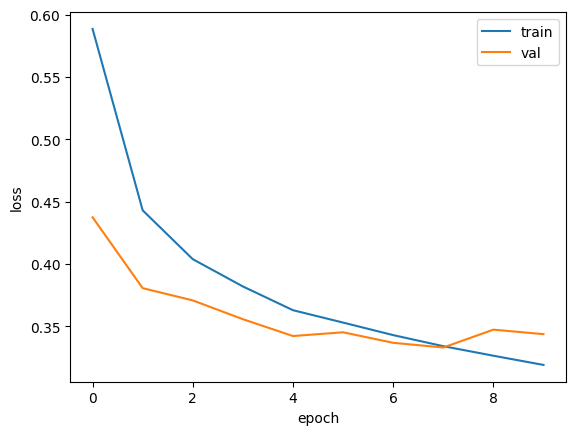

In [51]:
# 훈련 손실과 검증 손실을 출력해서 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [52]:
# 조기 종료로 얻은 모델로 검증 세트에 대한 성능 확인
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 0s 1ms/step - loss: 0.3329 - accuracy: 0.8809


[0.3329439163208008, 0.8809166550636292]